# Fitting Global Warming

It is well established that [global average temperatures have been rising](https://en.wikipedia.org/wiki/Climate_change) for many decades, and there is a [broad scientific consensus](https://www.ipcc.ch/) that this change is primarily due to human activity.

But over short timescales, the random year-to-year variations in temperature are large, making it harder for humans to notice the long-term trend.

How do we extract *average trends* from noisy data?  Linear algebra!

## Global temperature data 1973–2022:

The following is data on the change (°C) in [average global temperature](https://en.wikipedia.org/wiki/Global_temperature_record) (compared to the 1901–2000 average) since 1973 (the year Prof. Johnson was born), from the [National Centers for Environmental Information](https://www.ncdc.noaa.gov/cag/global/time-series/globe/land_ocean/1/1/1973-2022):

In [1]:
year = [1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
ΔT = [0.28, -0.19, 0.11, -0.02, 0.13, 0.16, 0.15, 0.33, 0.51, 0.14, 0.53, 0.3, 0.22, 0.31, 0.32, 0.56, 0.17, 0.36, 0.43, 0.46, 0.36, 0.27, 0.56, 0.25, 0.34, 0.6, 0.51, 0.34, 0.47, 0.71, 0.72, 0.61, 0.65, 0.5, 0.92, 0.27, 0.6, 0.73, 0.46, 0.44, 0.62, 0.69, 0.83, 1.12, 0.98, 0.75, 0.94, 1.14, 0.78, 0.89];

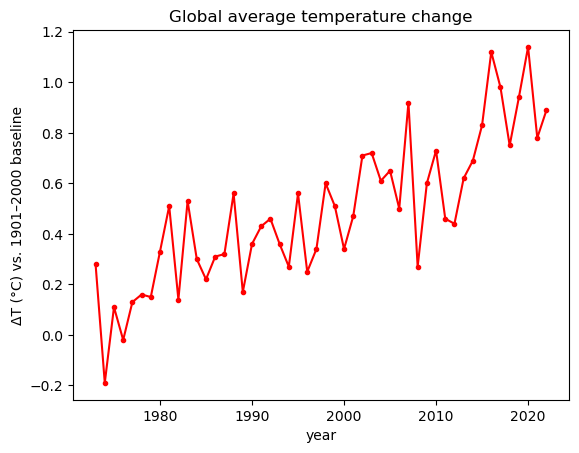

PyObject Text(0.5, 1.0, 'Global average temperature change')

In [7]:
using PyPlot
plot(year, ΔT, "r.-")
xlabel("year")
ylabel("ΔT (°C) vs. 1901–2000 baseline")
title("Global average temperature change")

Is this a big change?  For comparison, in [the most recent ice age](https://en.wikipedia.org/wiki/Last_Glacial_Maximum), the global average temperature was [about 6° C colder](https://www.smithsonianmag.com/smart-news/ice-age-temperature-science-how-cold-180975674/) than it is now … but that change took thousands of years.

So over my lifetime the temperature has changed by 1/6 of an ice age, [warming > 10× faster than after the ice age](https://royalsociety.org/topics-policy/projects/climate-change-evidence-causes/question-6/), and in fact changing faster than it has [for millions of years](https://news.stanford.edu/news/2013/august/climate-change-speed-080113.html).

![xkcd: Thickness of Ice Sheets](https://imgs.xkcd.com/comics/ice_sheets.png)

## Naive slope estimation: Pick two data points

If you would like to **estimate the slope** (the rate of **change of temperature per year**), a **naive** way would be to **pick two points** and draw a straight line through them, but this would be a pretty poor approach because the data is so noisy.

You will get **wildly varying slopes** depending on which years you picked, especially for years that are close together:

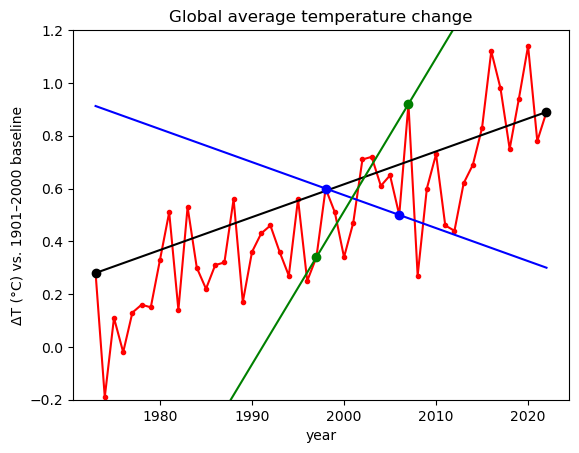

(-0.2, 1.2)

In [3]:
plot(year, ΔT, "r.-")
xlabel("year")
ylabel("ΔT (°C) vs. 1901–2000 baseline")
title("Global average temperature change")

for (i,j,c) in ((1,50,"k"), (26,34,"b"), (25,35,"g"))
    slope = (ΔT[j] - ΔT[i]) / (year[j] - year[i])
    plot(year[[i,j]], ΔT[[i,j]], "$(c)o")
    plot(year[[begin,end]], ΔT[i] .+ (year[[begin,end]] .- year[i]) .* slope, "$c-")
end

ylim(-0.2, 1.2)

Even using the first and last points is not that great of an estimate unless the timespan is extremely long (but over a longer timescale the change is not linear … in the last century it has accelerated enormously).

## Least-square fitting

Instead, a much more reliable approach is to look at *all* the data simultaneously.

We can't draw a single line that goes through all of the points, but we can try to minimize some *average* error between the fit and *all* of the points.   The most common approach is to minimize the average |error|², which is called a [least squares fit](https://en.wikipedia.org/wiki/Least_squares) or, in the particular case of fitting to a *line*, [linear regression](https://en.wikipedia.org/wiki/Linear_regression):

For example, if we want to fit to the linear model
$$
\mathrm{model}(\mathrm{year}) = \Delta T = x_1 + x_2 (\mathrm{year} - 1973)
$$
where $x_1$ is the intercept and $x_2$ is the slope, then sum of the squares of errors for $m$ data points is:
$$
\mathrm{SSE} = \sum_{k=1}^m \big[ \Delta T_k - \underbrace{\mathrm{model}(\mathrm{year}_k)}_{\mbox{row }k\mbox{ of }Ax} \big]^2
$$

### Matrix formulation

A key fact is that **this model depends linearly** on the **unknown x** parameters.  And so we can write it in terms of matrix and vector algebra.

In matrix form, we obtain:
$$
\mathrm{SSE} = \Vert b - Ax \Vert^2
$$
where
$$
A = \begin{pmatrix} 1 & \mathrm{year}_1 - 1973 \\ 1 & \mathrm{year}_2 - 1973 \\ \vdots & \vdots \\ 1 & \mathrm{year}_m - 1973 \end{pmatrix}, 
\qquad x = \begin{pmatrix} x_1 \\ x_2 \end{pmatrix}, \qquad b = \begin{pmatrix} \Delta T_1 \\ \Delta T_2 \\ \vdots \Delta T_m \end{pmatrix} \, .
$$
As we've seen in class, the minimum of $\Vert b - Ax \Vert^2$ is achieved by **orthogonal projection** of $b$ onto $C(A)$, corresponding to $\hat{x}$ solving the "normal equations"
$$
A^T A \hat{x} = A^T b
$$
or simply by `A \ b` in Julia:

In [4]:
b = ΔT
A = [ones(length(year)) year.-1973]

x̂ = A \ b

2-element Vector{Float64}:
 0.08468235294117633
 0.01638847539015606

In [5]:
# Alternatively, the normal equations solution:
(A'A) \ A'b

2-element Vector{Float64}:
 0.08468235294117676
 0.016388475390156053

Let's plot it:

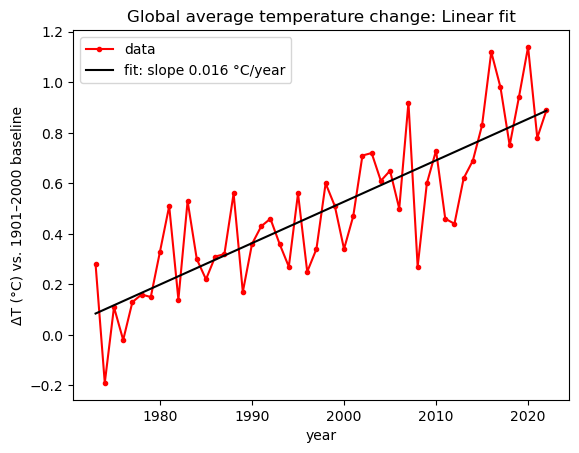

PyObject <matplotlib.legend.Legend object at 0x7fa7e579eca0>

In [6]:
using PyPlot
plot(year, ΔT, "r.-")
xlabel("year")
ylabel("ΔT (°C) vs. 1901–2000 baseline")
title("Global average temperature change: Linear fit")

plot(year, A * x̂, "k-")
legend(["data", "fit: slope $(round(x̂[2], sigdigits=2)) °C/year"])

It's obvious by eye that this fit line is a better description of the overall trend than any two data points.

More precisely, if the data noise is uncorrelated, then in a certain statistical sense a least-squares estimate is optimal, as described by the [Gauss–Markov theorem](https://en.wikipedia.org/wiki/Gauss%E2%80%93Markov_theorem).